In [1]:
import sys
sys.path.append(r"/n/home12/binxuwang/Github/Neuro-ActMax-GAN-comparison")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from collections import defaultdict
from pytorch_pretrained_biggan import BigGAN
from core.utils.GAN_utils import BigGAN_wrapper, Caffenet
from core.utils.layer_hook_utils import featureFetcher_module, featureFetcher
from core.utils.plot_utils import to_imgrid, make_grid, show_imgrid

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_pretrained_biggan import BigGAN, one_hot_from_names, truncated_noise_sample, one_hot_from_int
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, TensorDataset
from core.utils.GAN_utils import Caffenet  # Assuming Caffenet is defined in your utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Initialize Caffenet
caffenet_model = Caffenet()
caffenet_model.to(device)
caffenet_model.eval()

# Initialize BigGAN
BG = BigGAN.from_pretrained("biggan-deep-256")
#loadBigGAN()
BG.to(device).eval()
G = BigGAN_wrapper(BG)

In [5]:
# Sampling 5000 random latent codes
num_samples = 5000
latent_dim = 128  # BigGAN latent dimension
truncation = 0.7
latent_codes = truncated_noise_sample(truncation=truncation, batch_size=num_samples)
noise_latent_codes = torch.tensor(latent_codes, dtype=torch.float32).to(device)
class_ids = torch.randint(0, 1000, (num_samples,))
class_ids_one_hot = F.one_hot(class_ids, num_classes=1000)
# to one hot
class_latent_codes = G.BigGAN.embeddings(class_ids_one_hot.float().to(device))
print(class_latent_codes.shape) 
print(noise_latent_codes.shape)
latent_codes_all = torch.cat([noise_latent_codes, class_latent_codes], dim=1)

torch.Size([5000, 128])
torch.Size([5000, 128])


### Testing this 

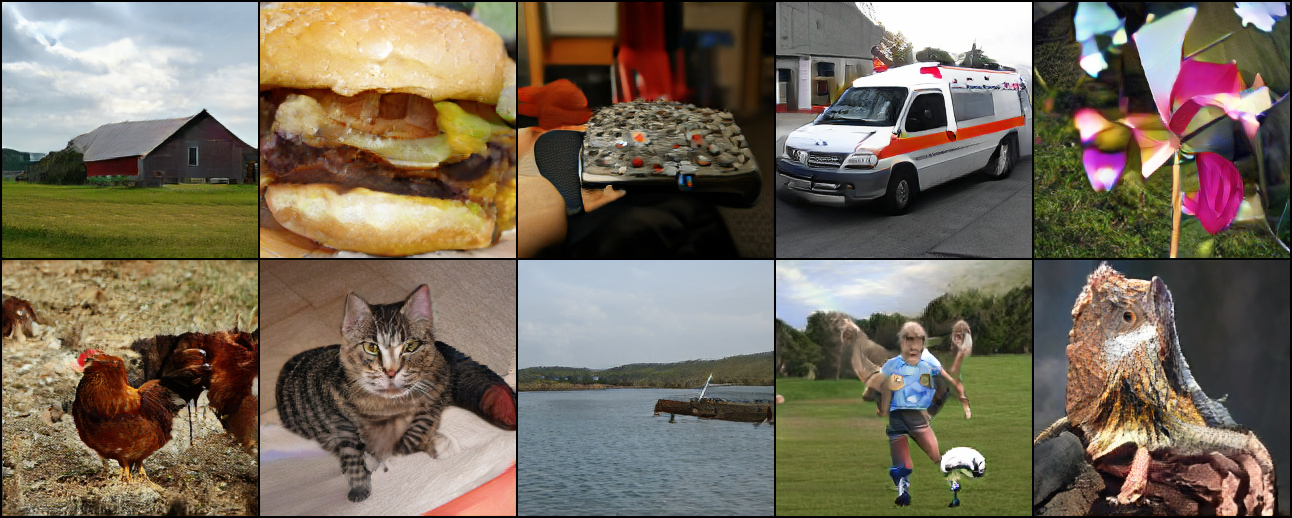

Image 0: Class ID 425 - barn
Image 1: Class ID 933 - cheeseburger
Image 2: Class ID 761 - remote_control
Image 3: Class ID 407 - ambulance
Image 4: Class ID 723 - pinwheel
Image 5: Class ID 8 - hen
Image 6: Class ID 281 - tabby
Image 7: Class ID 913 - wreck
Image 8: Class ID 805 - soccer_ball
Image 9: Class ID 43 - frilled_lizard


In [6]:
import json
import urllib.request

# Download ImageNet class index
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
response = urllib.request.urlopen(url)
imagenet_classes = json.loads(response.read())

latent_codes_all = torch.cat([noise_latent_codes, class_latent_codes], dim=1)
with torch.no_grad():
    imgs = G.visualize(latent_codes_all[:10])
    
display(to_imgrid(imgs, nrow=5))

for i in range(10):
    class_id = class_ids[i].item()
    class_name = imagenet_classes[str(class_id)][1]  # Get human readable class name
    print(f"Image {i}: Class ID {class_id} - {class_name}")


### Streaming and recording activations


In [6]:
def get_center_activation(tensor, max_channel=None):
    if max_channel is None:
        max_channel = tensor.shape[1]
    if len(tensor.shape) == 2:
        return tensor[:, :max_channel]
    elif len(tensor.shape) == 4:
        B, C, H, W = tensor.shape
        return tensor[:, :max_channel, H//2, W//2]
    else:
        raise ValueError(f"Expected tensor with 2 or 4 dimensions, got {len(tensor.shape)}")

In [7]:
fetcher = featureFetcher_module()

for name, layer in caffenet_model.net.named_children():
    if name == "flatten":
        continue
    fetcher.record_module(layer, name, ingraph=False, store_device="cpu")


In [8]:
# Define transformation to match Caffenet input requirements
transform = transforms.Compose([
    transforms.Resize(224),
    # Note no need to normalize, as the model perform normalization inside
])

activation_storage = defaultdict(list)

# Create DataLoader for batch processing
batch_size = 64
for csr in trange(0, len(latent_codes_all), batch_size):
    latent_codes_all_batch = latent_codes_all[csr:csr+batch_size]
    with torch.no_grad():
        imgs = G.visualize(latent_codes_all_batch)
    imgs = transform(imgs)
    with torch.no_grad():
        _ = caffenet_model(imgs, preproc=True)
    
    for name, activation in fetcher.activations.items():
        activation_storage[name].append(get_center_activation(activation))

# Concatenate activations
for layer in activation_storage:
    activation_storage[layer] = torch.cat(activation_storage[layer], dim=0)

  0%|          | 0/79 [00:00<?, ?it/s]

In [9]:
for layer in activation_storage:
    print(layer, activation_storage[layer].shape)

conv1 torch.Size([5000, 96])
relu1 torch.Size([5000, 96])
pool1 torch.Size([5000, 96])
norm1 torch.Size([5000, 96])
conv2 torch.Size([5000, 256])
relu2 torch.Size([5000, 256])
pool2 torch.Size([5000, 256])
norm2 torch.Size([5000, 256])
conv3 torch.Size([5000, 384])
relu3 torch.Size([5000, 384])
conv4 torch.Size([5000, 384])
relu4 torch.Size([5000, 384])
conv5 torch.Size([5000, 256])
relu5 torch.Size([5000, 256])
pool5 torch.Size([5000, 256])
fc6 torch.Size([5000, 4096])
relu6 torch.Size([5000, 4096])
fc7 torch.Size([5000, 4096])
relu7 torch.Size([5000, 4096])
fc8 torch.Size([5000, 1000])


#### Reverse Regression: Caffenet activations predicting BigGAN latent codes

In [12]:
X = latent_codes_all.detach().cpu().numpy()
results = []

for layer, activation in activation_storage.items():
    # For each target neuron in the layer
    # target_idx = np.arange(activation.shape[1])
    y = activation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_noise = X_train[:, :128]
    X_train_class = X_train[:, 128:]
    X_test_noise = X_test[:, :128]
    X_test_class = X_test[:, 128:]
    # Ridge Regression
    ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(y_train, X_train)
    # Calculate R2 score for each target neuron using vectorized operation
    r2_train = r2_score(X_train, ridge.predict(y_train), multioutput=None)
    r2_scores = r2_score(X_test, ridge.predict(y_test), multioutput=None)
    
    ridge_class = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(y_train, X_train_class)
    r2_scores_class = r2_score(X_test_class, ridge_class.predict(y_test))
    r2_train_class = r2_score(X_train_class, ridge_class.predict(y_train))

    ridge_noise = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(y_train, X_train_noise)
    r2_scores_noise = r2_score(X_test_noise, ridge_noise.predict(y_test))
    r2_train_noise = r2_score(X_train_noise, ridge_noise.predict(y_train))
    # Create dictionary entries for all targets at once

    results.append({
        'Layer': layer,
        'num_features': activation.shape[1],
        'reverse_Train_R2': r2_train,
        'reverse_Test_R2': r2_scores,
        'reverse_Train_R2_class': r2_train_class,
        'reverse_Test_R2_class': r2_scores_class,
        'reverse_Train_R2_noise': r2_train_noise,
        'reverse_Test_R2_noise': r2_scores_noise
    })

# Summarize results
reverse_results_df = pd.DataFrame(results)

In [15]:
reverse_results_df

Layer  num_features  reverse_Train_R2  reverse_Test_R2  \
0   conv1            96          0.029472         0.008778   
1   relu1            96          0.045852         0.014435   
2   pool1            96          0.053799         0.016954   
3   norm1            96          0.052777         0.026806   
4   conv2           256          0.106398         0.036326   
5   relu2           256          0.088800         0.033689   
6   pool2           256          0.118137         0.042717   
7   norm2           256          0.111598         0.047065   
8   conv3           384          0.148359         0.063026   
9   relu3           384          0.139025         0.057857   
10  conv4           384          0.150755         0.071857   
11  relu4           384          0.125961         0.059246   
12  conv5           256          0.136388         0.073324   
13  relu5           256          0.108525         0.062390   
14  pool5           256          0.147299         0.085908   
15    fc6          4096          0.333398         0.164561   
16  relu6          4096          0.388407         0.240171   
17    fc7          4096          0.348772         0.225034   
18  relu7          4096          0.380507         0.268709   
19    fc8          1000          0.299452         0.230907   

    reverse_Train_R2_class  reverse_Test_R2_class  reverse_Train_R2_noise  \
0                 0.045259               0.025886                0.013684   
1                 0.070792               0.038741                0.020913   
2                 0.083655               0.046600                0.023942   
3                 0.084374               0.059259                0.021180   
4                 0.160024               0.093091                0.052771   
5                 0.131519               0.079486                0.046081   
6                 0.176549               0.105372                0.059725   
7                 0.168712               0.107186                0.054485   
8                 0.223183               0.144815                0.073535   
9                 0.207852               0.131156                0.070197   
10                0.231193               0.158351                0.070317   
11                0.197788               0.125633                0.054134   
12                0.227758               0.154165                0.045017   
13                0.194368               0.126955                0.022682   
14                0.255210               0.175219                0.039389   
15                0.472173               0.339707                0.194622   
16                0.677070               0.475721                0.099745   
17                0.651584               0.447537                0.045961   
18                0.731193               0.537183                0.029821   
19                0.584552               0.462567                0.014352   

    reverse_Test_R2_noise  
0               -0.008330  
1               -0.009871  
2               -0.012691  
3               -0.005648  
4               -0.020440  
5               -0.012107  
6               -0.019939  
7               -0.013056  
8               -0.018764  
9               -0.015443  
10              -0.014638  
11              -0.007140  
12              -0.007516  
13              -0.002175  
14              -0.003402  
15              -0.010585  
16               0.004621  
17               0.002531  
18               0.000235  
19              -0.000754

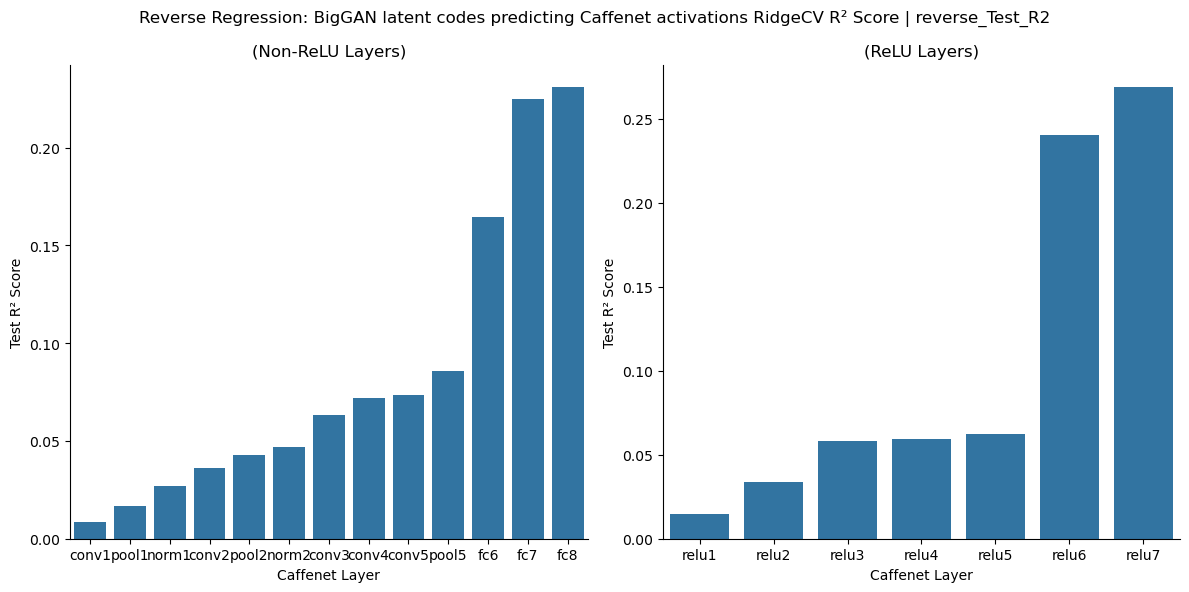

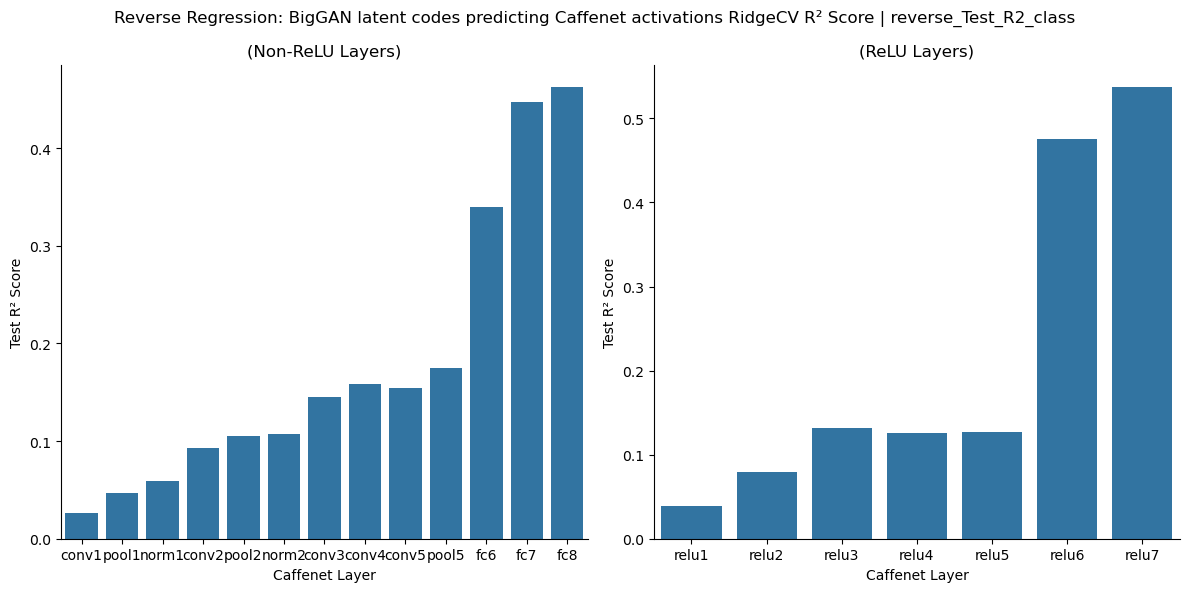

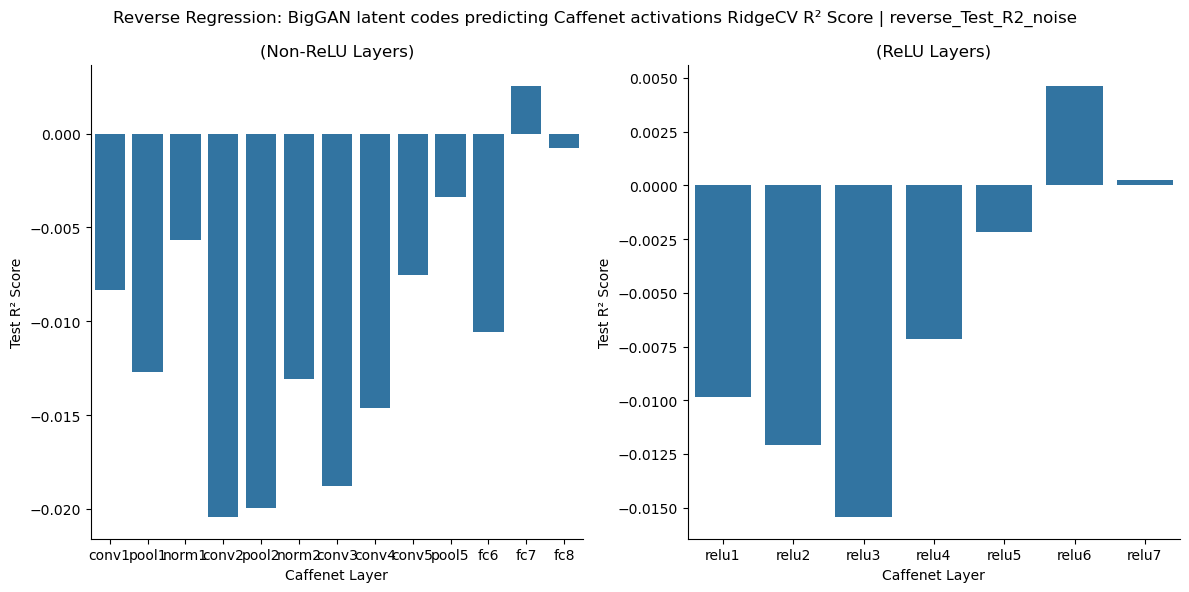

In [20]:
for y_variable in ['reverse_Test_R2', 'reverse_Test_R2_class', 'reverse_Test_R2_noise']:
    figh, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sns.barplot(x='Layer', y=y_variable, data=reverse_results_df.query('not Layer.str.contains("relu")'), ax=ax1)
    ax1.set_title('(Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    sns.barplot(x='Layer', y=y_variable, data=reverse_results_df.query('Layer.str.contains("relu")'), ax=ax2)
    ax2.set_title('(ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    plt.suptitle(f'Reverse Regression: BigGAN latent codes predicting Caffenet activations RidgeCV R² Score | {y_variable}')
    plt.tight_layout()
    plt.show()

#### Forward Regression: BigGAN latent codes predicting Caffenet activations

In [31]:
X = latent_codes_all.cpu().numpy()
results = []

for layer, activation in activation_storage.items():
    # For each target neuron in the layer
    target_idx = np.arange(activation.shape[1])
    y = activation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_noise = X_train[:, :128]
    X_train_class = X_train[:, 128:]
    X_test_noise = X_test[:, :128]
    X_test_class = X_test[:, 128:]
    # Ridge Regression
    ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train, y_train)
    # Calculate R2 score for each target neuron using vectorized operation
    r2_train = r2_score(y_train, ridge.predict(X_train), multioutput='raw_values')
    r2_scores = r2_score(y_test, ridge.predict(X_test), multioutput='raw_values')
    
    ridge_class = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train_class, y_train)
    r2_scores_class = r2_score(y_test, ridge_class.predict(X_test_class), multioutput='raw_values')
    r2_train_class = r2_score(y_train, ridge_class.predict(X_train_class), multioutput='raw_values')

    ridge_noise = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train_noise, y_train)
    r2_scores_noise = r2_score(y_test, ridge_noise.predict(X_test_noise), multioutput='raw_values')
    r2_train_noise = r2_score(y_train, ridge_noise.predict(X_train_noise), multioutput='raw_values')
    # Create dictionary entries for all targets at once

    results.extend([{
        'Layer': layer,
        'Target': idx,
        'Train_R2': r2_train[idx],
        'Test_R2': r2_scores[idx],
        'Train_R2_class': r2_train_class[idx],
        'Test_R2_class': r2_scores_class[idx],
        'Train_R2_noise': r2_train_noise[idx],
        'Test_R2_noise': r2_scores_noise[idx]
    } for idx in zip(target_idx)])


# Summarize results
results_df = pd.DataFrame(results)

In [55]:
from core.utils.plot_utils import saveallforms


In [54]:
import pickle as pkl
from os.path import join
savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\BigGAN_Caffenet"
os.makedirs(savedir, exist_ok=True)

# Save the full results DataFrame
results_df.to_csv(join(savedir, "latent_code_linearity_results.csv"), index=False)

# Save summary statistics per layer
layer_summary = results_df.groupby('Layer').agg({
    'Test_R2': ['mean', 'std', 'median'],
    'Test_R2_class': ['mean', 'std', 'median'], 
    'Test_R2_noise': ['mean', 'std', 'median']
}).round(4)
layer_summary.to_csv(join(savedir, "layer_summary_stats.csv"))

# Save the raw data used for analysis
pkl.dump({"latent_codes": latent_codes_all.cpu(), 
          "class_ids": class_ids.cpu(),
          "activation_storage": activation_storage}, open(join(savedir, "BigGAN_Caffenet_data.pkl"), "wb"))

In [76]:
savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\BigGAN_Caffenet"
results_df = pd.read_csv(join(savedir, "latent_code_linearity_results.csv"))

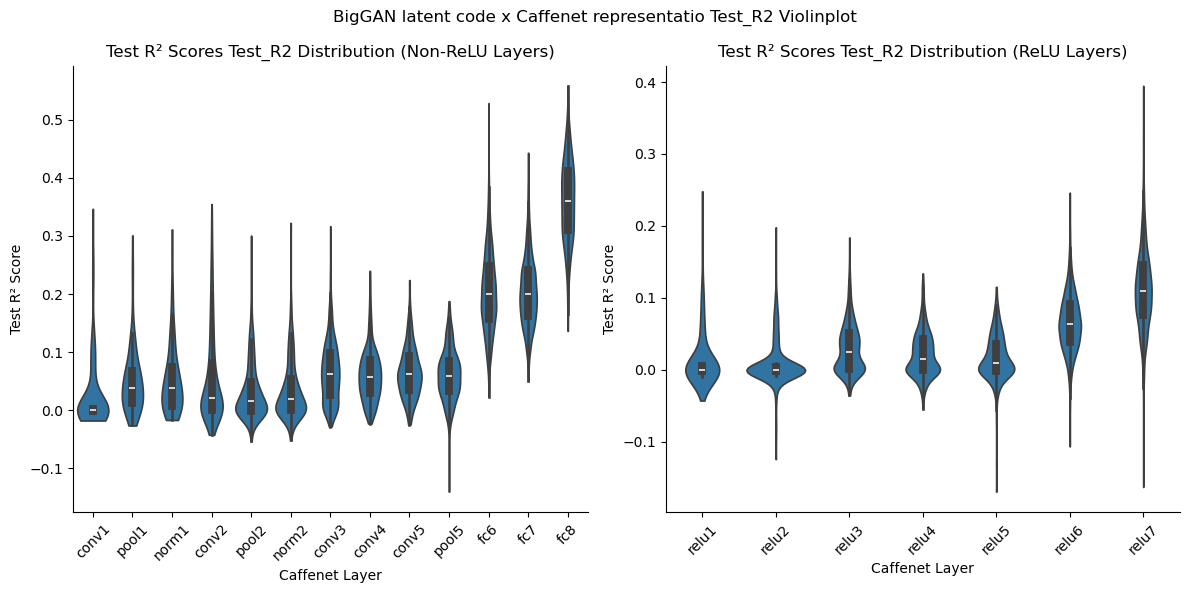

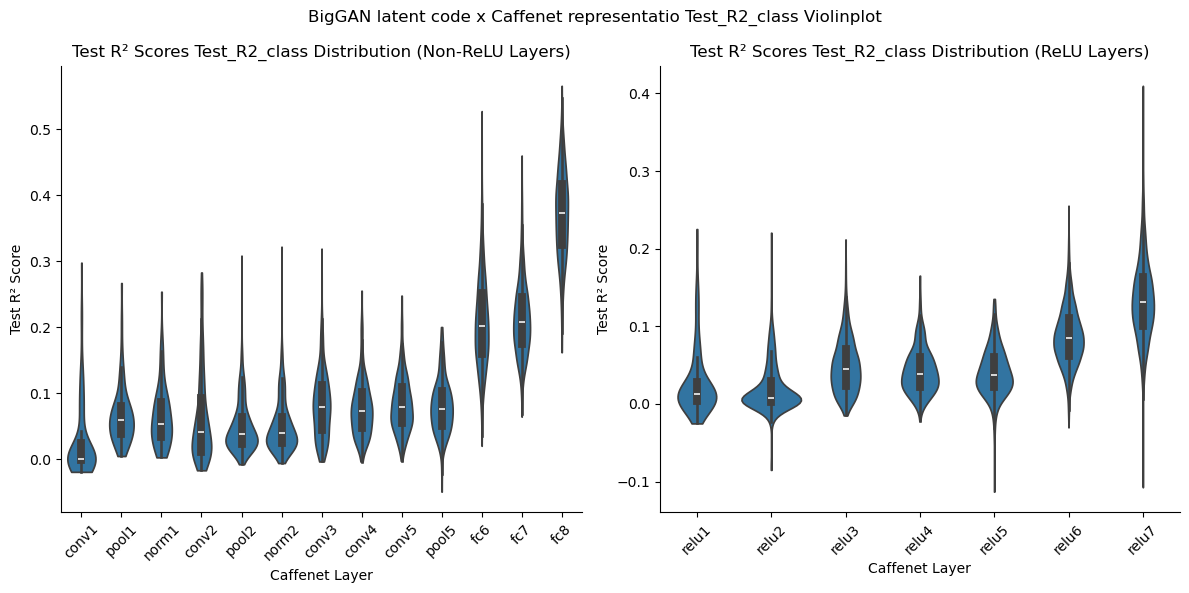

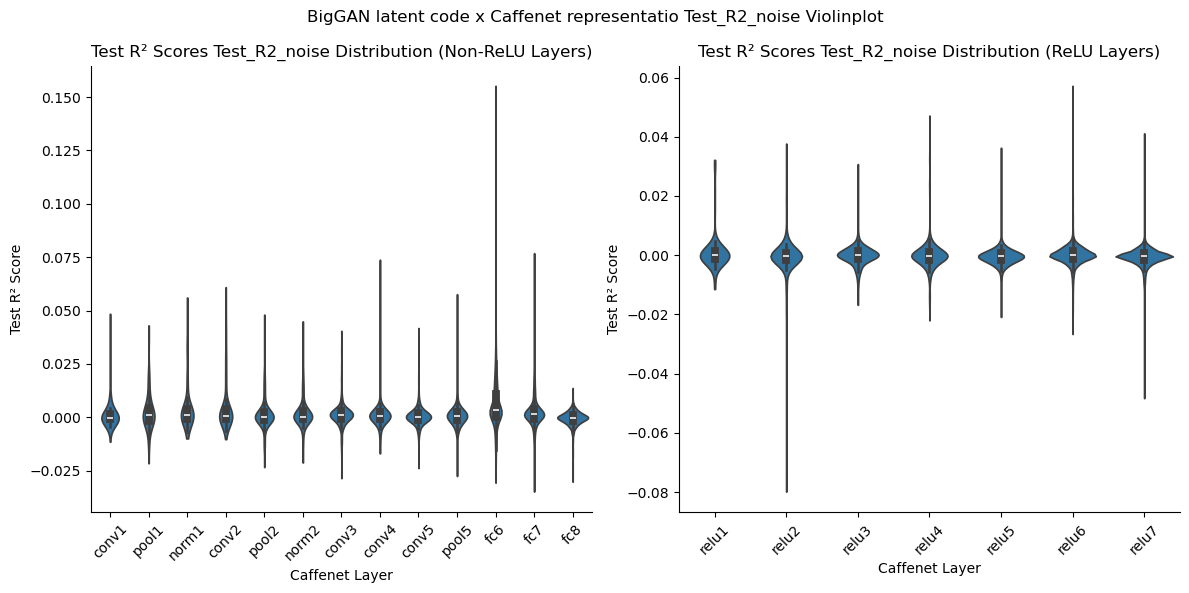

In [77]:
# Plot the results
for y_variable in ["Test_R2", 'Test_R2_class', 'Test_R2_noise']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot for layers without relu
    sns.violinplot(x='Layer', y=y_variable, 
            data=results_df.query('not Layer.str.contains("relu")'), 
            ax=ax1, cut=0)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title(f'Test R² Scores {y_variable} Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    # Plot for relu layers
    sns.violinplot(x='Layer', y=y_variable,
            data=results_df.query('Layer.str.contains("relu")'),
            ax=ax2, cut=0)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores {y_variable} Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    plt.suptitle(f"BigGAN latent code x Caffenet representatio {y_variable} Violinplot")
    plt.tight_layout()
    saveallforms(savedir, f"BigGAN_Caffenet_{y_variable}_violinplot")
    plt.show()


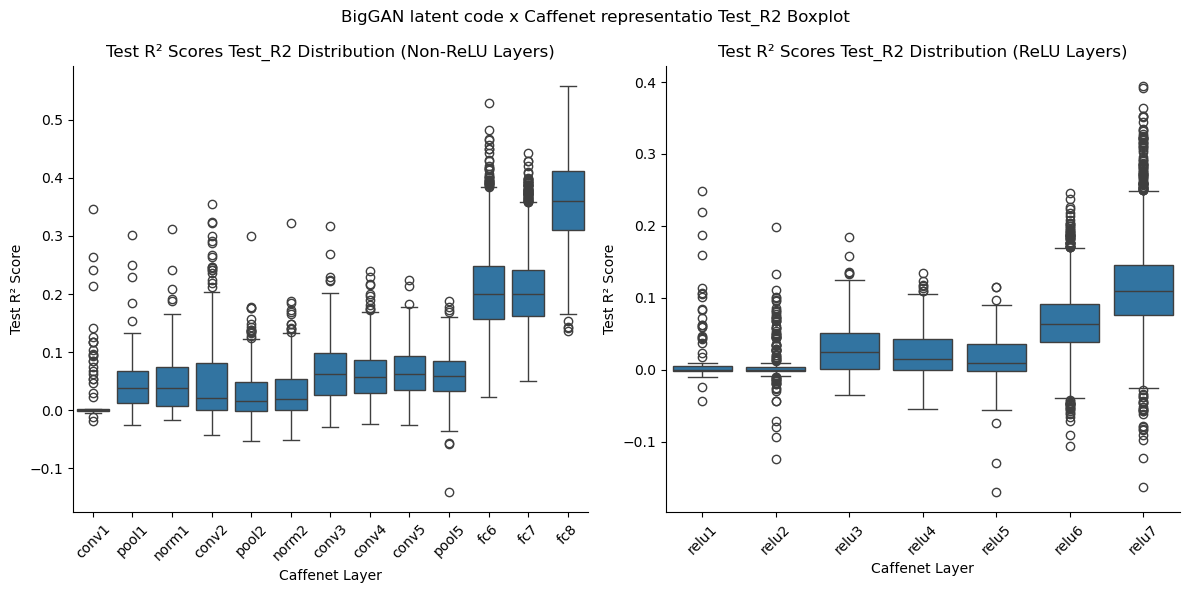

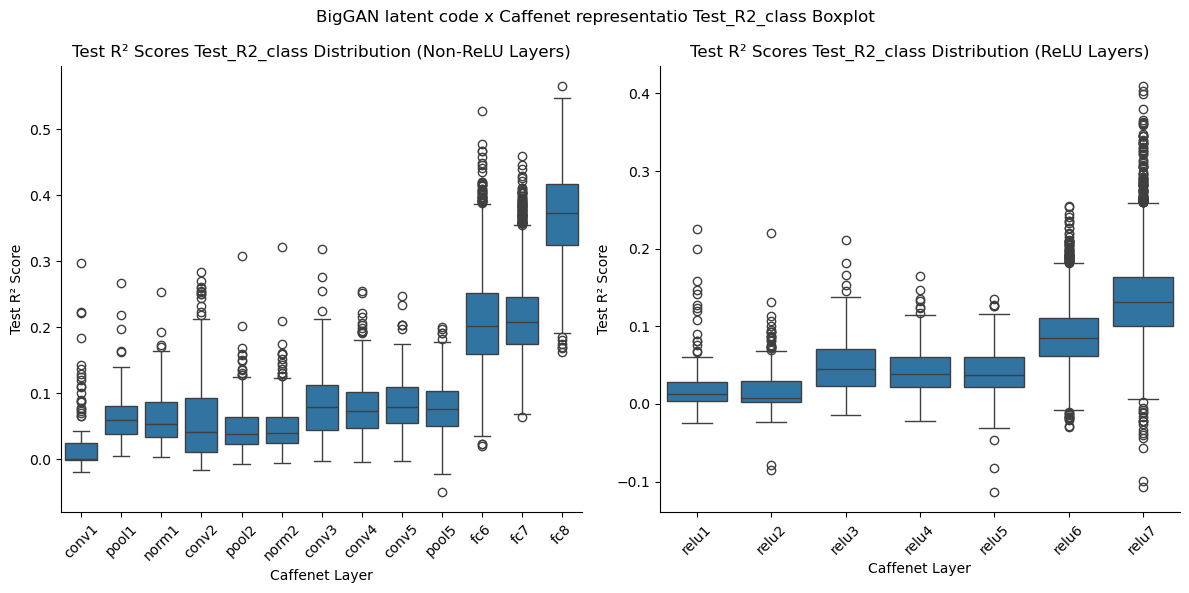

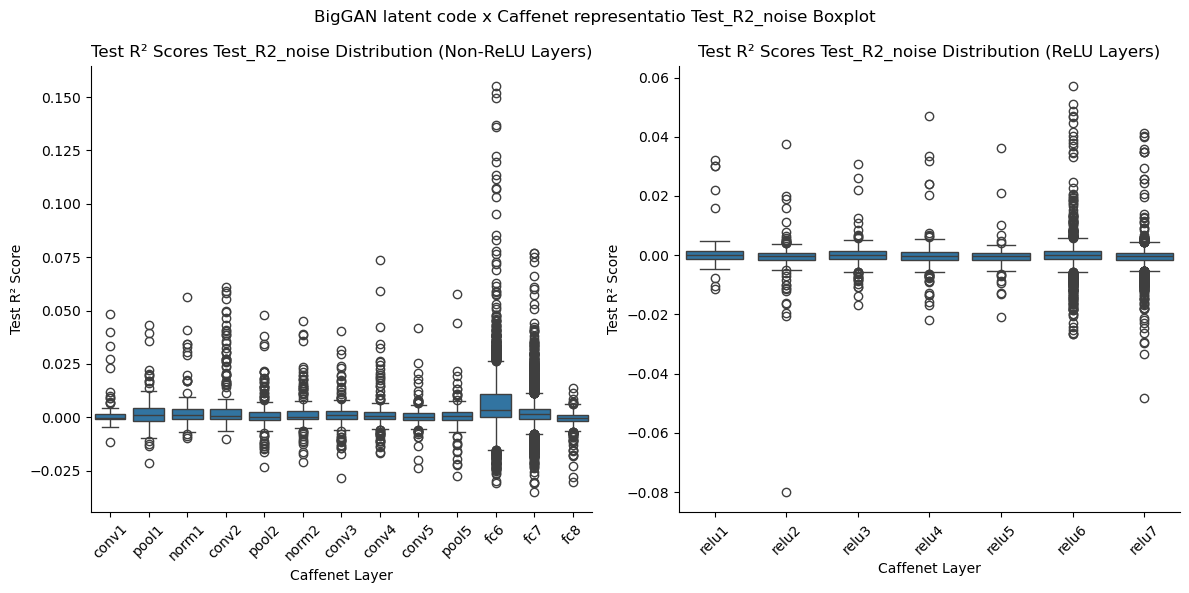

In [78]:
# Plot the results
for y_variable in ["Test_R2", 'Test_R2_class', 'Test_R2_noise']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot for layers without relu
    sns.boxplot(x='Layer', y=y_variable, 
            data=results_df.query('not Layer.str.contains("relu")'), 
            ax=ax1, )
    ax1.tick_params(axis='x', rotation=45)

    ax1.set_title(f'Test R² Scores {y_variable} Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    # Plot for relu layers
    sns.boxplot(x='Layer', y=y_variable,
            data=results_df.query('Layer.str.contains("relu")'),
            ax=ax2, )
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores {y_variable} Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    plt.suptitle(f"BigGAN latent code x Caffenet representatio {y_variable} Boxplot")
    plt.tight_layout()
    saveallforms(savedir, f"BigGAN_Caffenet_{y_variable}_boxplot")
    plt.show()

### Local linearity of BigGAN latent codes



In [29]:
def process_latent_codes(latent_codes_all, G, caffenet_model, fetcher, transform=None, batch_size=64):
    # Define transformation to match Caffenet input requirements
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(224),
            # Note no need to normalize, as the model perform normalization inside
        ])
    
    activation_storage = defaultdict(list)
    
    # Create DataLoader for batch processing
    for csr in trange(0, len(latent_codes_all), batch_size):
        latent_codes_all_batch = latent_codes_all[csr:csr+batch_size]
        with torch.no_grad():
            imgs = G.visualize(latent_codes_all_batch)
        imgs = transform(imgs)
        with torch.no_grad():
            _ = caffenet_model(imgs, preproc=True)
        
        for name, activation in fetcher.activations.items():
            activation_storage[name].append(get_center_activation(activation))
    
    # Concatenate activations
    for layer in activation_storage:
        activation_storage[layer] = torch.cat(activation_storage[layer], dim=0)
    
    return activation_storage

In [35]:
def forward_regression_predict_activations(activation_storage, latent_codes_all):
    """
    Processes activation storage and latent codes to compute R² scores.

    Parameters:
        activation_storage (dict): Dictionary containing activations for each layer.
        latent_codes_all (torch.Tensor): Tensor containing all latent codes.

    Returns:
        pd.DataFrame: DataFrame summarizing the R² scores for each layer and target.
    """
    X = latent_codes_all.detach().cpu().numpy()
    results = []

    for layer, activation in activation_storage.items():
        # For each target neuron in the layer
        target_idx = np.arange(activation.shape[1])
        y = activation.detach().cpu().numpy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train_noise = X_train[:, :128]
        X_train_class = X_train[:, 128:]
        X_test_noise = X_test[:, :128]
        X_test_class = X_test[:, 128:]
        # Ridge Regression
        ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train, y_train)
        # Calculate R2 score for each target neuron using vectorized operation
        r2_train = r2_score(y_train, ridge.predict(X_train), multioutput='raw_values')
        r2_scores = r2_score(y_test, ridge.predict(X_test), multioutput='raw_values')
        
        ridge_class = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train_class, y_train)
        r2_scores_class = r2_score(y_test, ridge_class.predict(X_test_class), multioutput='raw_values')
        r2_train_class = r2_score(y_train, ridge_class.predict(X_train_class), multioutput='raw_values')
    
        ridge_noise = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train_noise, y_train)
        r2_scores_noise = r2_score(y_test, ridge_noise.predict(X_test_noise), multioutput='raw_values')
        r2_train_noise = r2_score(y_train, ridge_noise.predict(X_train_noise), multioutput='raw_values')
        # Create dictionary entries for all targets at once

        results.extend([{
            'Layer': layer,
            'Target': idx[0],
            'Train_R2': r2_train[idx[0]],
            'Test_R2': r2_scores[idx[0]],
            'Train_R2_class': r2_train_class[idx[0]],
            'Test_R2_class': r2_scores_class[idx[0]],
            'Train_R2_noise': r2_train_noise[idx[0]],
            'Test_R2_noise': r2_scores_noise[idx[0]]
        } for idx in zip(target_idx)])

    # Summarize results
    results_df = pd.DataFrame(results)
    return results_df

def reverse_regression_predict_latent_codes(activation_storage, latent_codes_all):
    """
    Processes activation storage and latent codes to compute R² scores.

    Parameters:
        activation_storage (dict): Dictionary containing activations for each layer.
        latent_codes_all (torch.Tensor): Tensor containing all latent codes.

    Returns:
        pd.DataFrame: DataFrame summarizing the R² scores for each layer and target.
    """
    X = latent_codes_all.detach().cpu().numpy()
    results = []

    for layer, activation in activation_storage.items():
        # For each target neuron in the layer
        # target_idx = np.arange(activation.shape[1])
        y = activation.detach().cpu().numpy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train_noise = X_train[:, :128]
        X_train_class = X_train[:, 128:]
        X_test_noise = X_test[:, :128]
        X_test_class = X_test[:, 128:]
        # Ridge Regression
        ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(y_train, X_train)
        # Calculate R2 score for each target neuron using vectorized operation
        r2_train = r2_score(X_train, ridge.predict(y_train), multioutput=None)
        r2_scores = r2_score(X_test, ridge.predict(y_test), multioutput=None)
        
        ridge_class = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(y_train, X_train_class)
        r2_scores_class = r2_score(X_test_class, ridge_class.predict(y_test))
        r2_train_class = r2_score(X_train_class, ridge_class.predict(y_train))

        ridge_noise = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(y_train, X_train_noise)
        r2_scores_noise = r2_score(X_test_noise, ridge_noise.predict(y_test))
        r2_train_noise = r2_score(X_train_noise, ridge_noise.predict(y_train))
        # Create dictionary entries for all targets at once

        results.append({
            'Layer': layer,
            'num_features': activation.shape[1],
            'reverse_Train_R2': r2_train,
            'reverse_Test_R2': r2_scores,
            'reverse_Train_R2_class': r2_train_class,
            'reverse_Test_R2_class': r2_scores_class,
            'reverse_Train_R2_noise': r2_train_noise,
            'reverse_Test_R2_noise': r2_scores_noise
        })

    # Summarize results
    reverse_results_df = pd.DataFrame(results)
    return reverse_results_df


In [66]:
def plot_forward_r2_scores_distribution(results_df, savedir=None, plot_type="boxplot"):
    """
    Plots the distribution of Test R² scores for Non-ReLU and ReLU layers.

    Args:
        results_df (pd.DataFrame): DataFrame containing the R² scores.
        savedir (str): Directory to save the plot.

    Returns:
        None
    """
    melted_df = results_df.melt(id_vars=['Layer'], value_vars=["Test_R2", 'Test_R2_class', 'Test_R2_noise'], var_name='Metric', value_name='Score')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1.5, 1]})
    if plot_type == "boxplot":
        sns.boxplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("not Layer.str.contains('relu')"), ax=ax1)
    elif plot_type == "violinplot":
        sns.violinplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("not Layer.str.contains('relu')"), ax=ax1)
    elif plot_type == "stripplot":
        sns.stripplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("not Layer.str.contains('relu')"), ax=ax1, dodge=True)
    elif plot_type == "barplot":
        sns.barplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("not Layer.str.contains('relu')"), ax=ax1)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title(f'Test R² Scores Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')
    YLIM = ax1.get_ylim()
    ax1.set_ylim(max(-0.3, YLIM[0]), min(1, YLIM[1]))
    if plot_type == "boxplot":
        sns.boxplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("Layer.str.contains('relu')"), ax=ax2)
    elif plot_type == "violinplot":
        sns.violinplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("Layer.str.contains('relu')"), ax=ax2)
    elif plot_type == "stripplot":
        sns.stripplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("Layer.str.contains('relu')"), ax=ax2, dodge=True)
    elif plot_type == "barplot":
        sns.barplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("Layer.str.contains('relu')"), ax=ax2)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    # if ylim negative limit is too low, set it to -0.3
    YLIM = ax2.get_ylim()
    ax2.set_ylim(max(-0.3, YLIM[0]), min(1, YLIM[1]))
    plt.suptitle("Forward Regression: BigGAN latent code predicting Caffenet representation of each layer [center column]")
    plt.tight_layout()
    if savedir is not None:
        saveallforms(savedir, "BigGAN_Caffenet_combined_boxplot")
    plt.show()
    return fig

# Example usage:
# plot_r2_scores_distribution(results_df, savedir)

def plot_reverse_regression_results(reverse_results_df, savedir=None, plot_type="barplot",):
    """
    Plots the reverse regression results as grouped bar plots for Non-ReLU and ReLU layers.

    Args:
        reverse_results_df (pd.DataFrame): DataFrame containing the reverse regression R² scores.
        savedir (str): Directory to save the plot.

    Returns:
        None
    """
    y_variables = ['reverse_Test_R2', 'reverse_Test_R2_class', 'reverse_Test_R2_noise']
    reverse_melted_df = reverse_results_df.melt(id_vars='Layer', value_vars=y_variables, var_name='Metric', value_name='Test_R2_Score')

    figh, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1.5, 1]})
    sns.barplot(x='Layer', y='Test_R2_Score', hue='Metric', data=reverse_melted_df.query('not Layer.str.contains("relu")'), ax=ax1)
    ax1.set_title('(Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')
    ax1.legend(title='Metric')
    YLIM = ax1.get_ylim()
    ax1.set_ylim(max(-0.3, YLIM[0]), min(1, YLIM[1]))

    sns.barplot(x='Layer', y='Test_R2_Score', hue='Metric', data=reverse_melted_df.query('Layer.str.contains("relu")'), ax=ax2)
    ax2.set_title('(ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    ax2.legend(title='Metric')
    YLIM = ax2.get_ylim()
    ax2.set_ylim(max(-0.3, YLIM[0]), min(1, YLIM[1]))

    plt.suptitle('Reverse Regression: BigGAN Latent Codes Predicting Caffenet Activations RidgeCV R² Scores')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if savedir is not None:
        saveallforms(savedir, "BigGAN_Caffenet_reverse_regression_grouped_barplot")
    plt.show()

# Example usage:
# plot_reverse_regression_results(reverse_results_df, savedir)


In [58]:
noise_std = 0.1
random_center_vector = G.sample_vector(1, class_id=200)
latent_codes_local_lin = (random_center_vector + noise_std * torch.randn(200, 256, device=device)).detach()

In [59]:
local_lin_activation_storage = process_latent_codes(latent_codes_local_lin, G, caffenet_model, fetcher)
local_lin_results_df = forward_regression_predict_activations(local_lin_activation_storage, latent_codes_local_lin)
local_lin_reverse_results_df = reverse_regression_predict_latent_codes(local_lin_activation_storage, latent_codes_local_lin)

  0%|          | 0/4 [00:00<?, ?it/s]

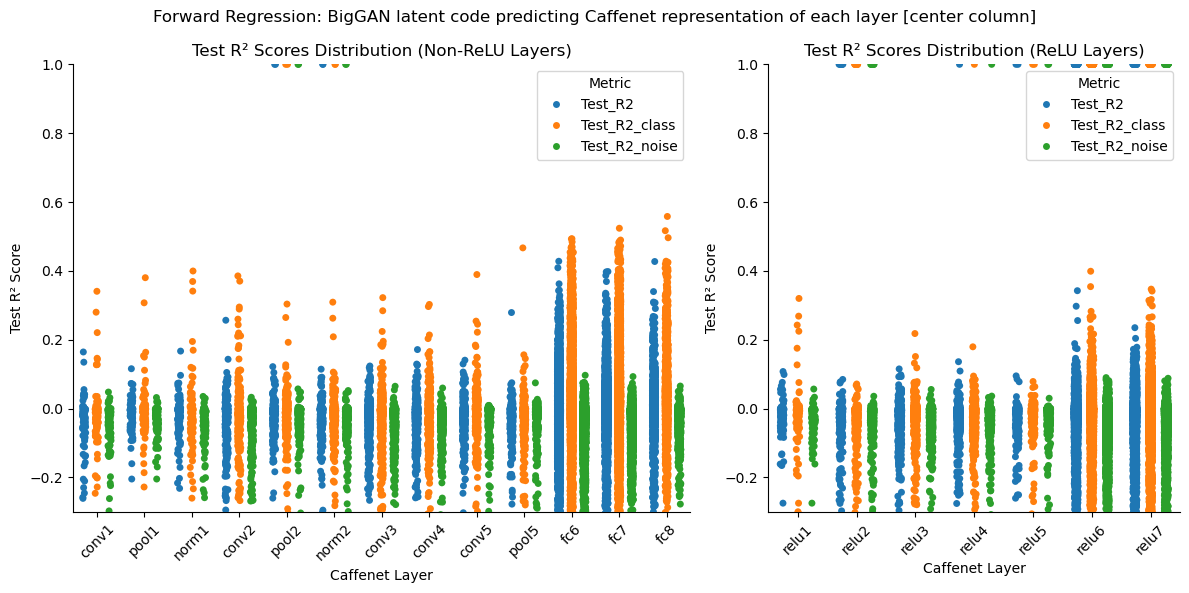

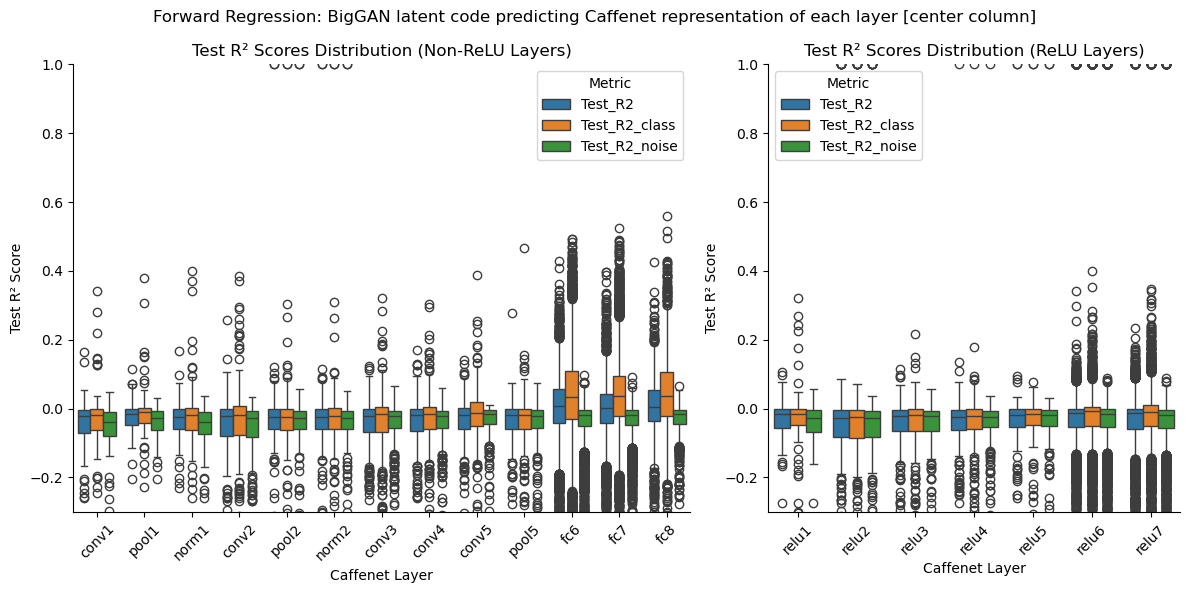

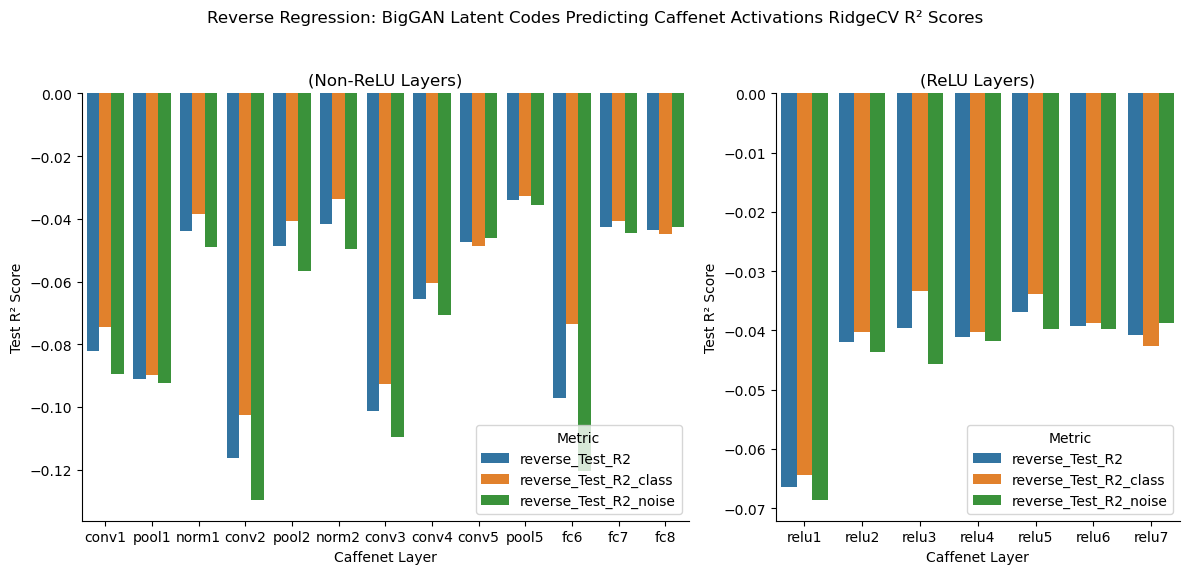

In [62]:
plot_forward_r2_scores_distribution(local_lin_results_df, plot_type="stripplot");
plot_forward_r2_scores_distribution(local_lin_results_df, plot_type="boxplot");
plot_reverse_regression_results(local_lin_reverse_results_df, )

  0%|          | 0/16 [00:00<?, ?it/s]

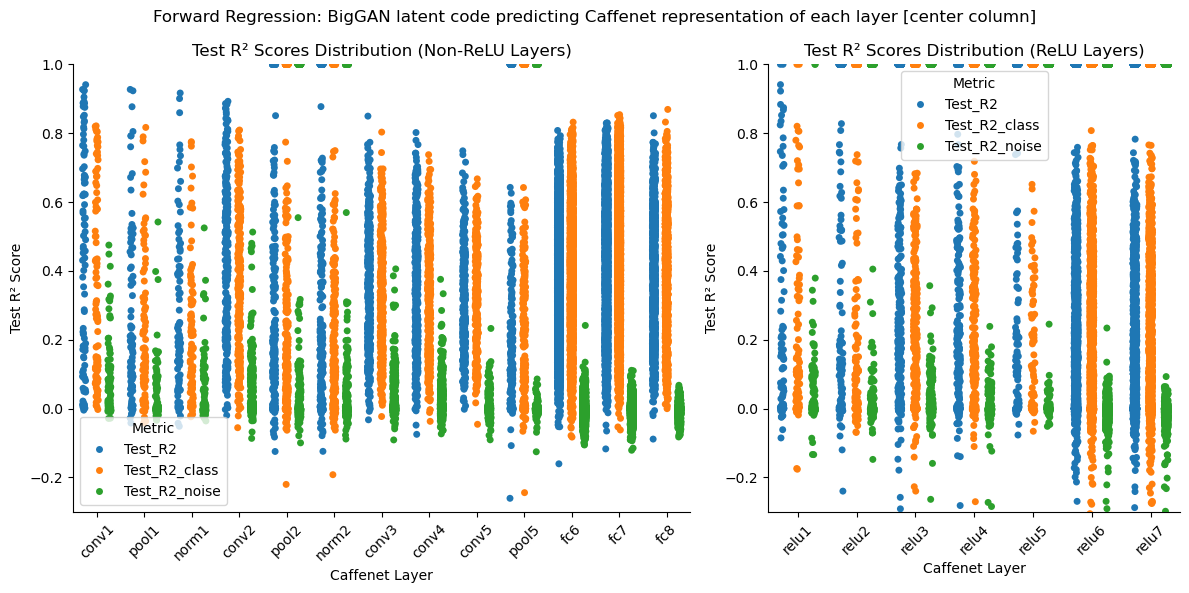

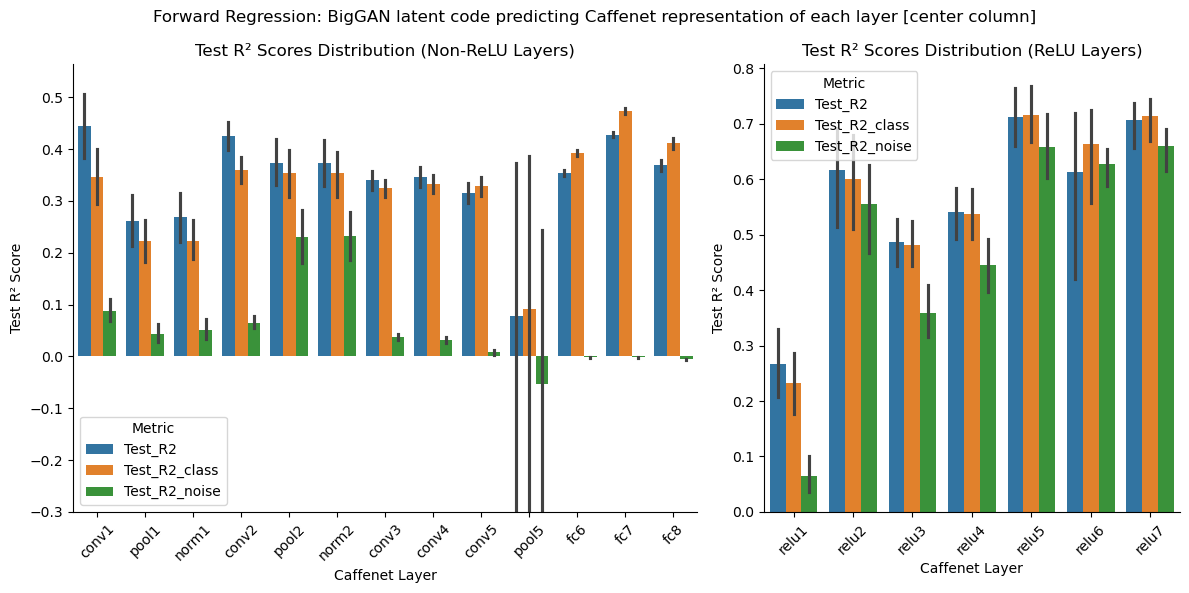

In [71]:
noise_std = 0.01
random_center_vector = G.sample_vector(1, class_id=256)
latent_codes_local_lin = (random_center_vector + noise_std * torch.randn(1000, 256, device=device)).detach()
local_lin_activation_storage = process_latent_codes(latent_codes_local_lin, G, caffenet_model, fetcher)
local_lin_results_df = forward_regression_predict_activations(local_lin_activation_storage, latent_codes_local_lin)
local_lin_reverse_results_df = reverse_regression_predict_latent_codes(local_lin_activation_storage, latent_codes_local_lin)
plot_forward_r2_scores_distribution(local_lin_results_df, plot_type="stripplot");
plot_forward_r2_scores_distribution(local_lin_results_df, plot_type="barplot");

  0%|          | 0/16 [00:00<?, ?it/s]

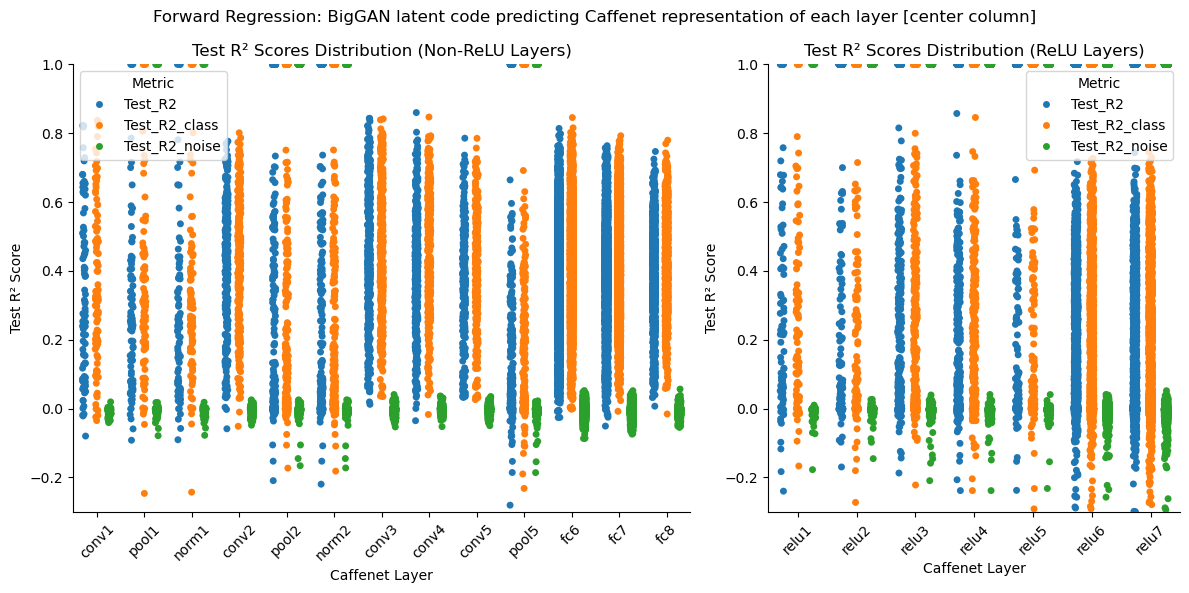

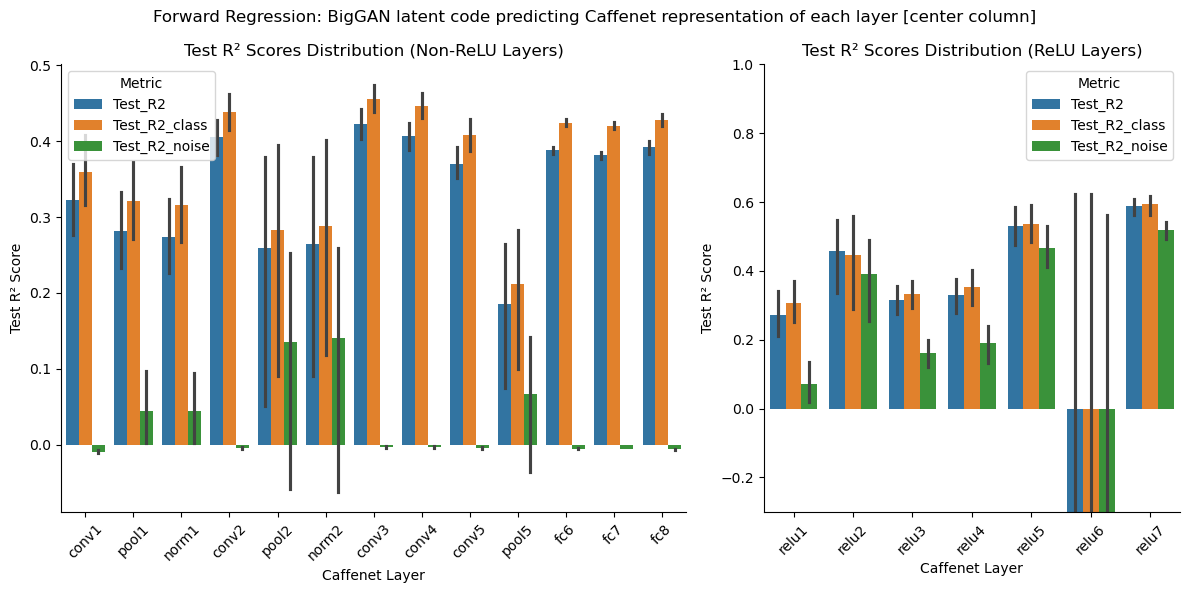

In [70]:
noise_std = 0.02
random_center_vector = G.sample_vector(1, class_id=256)
latent_codes_local_lin = (random_center_vector + noise_std * torch.randn(1000, 256, device=device)).detach()
local_lin_activation_storage = process_latent_codes(latent_codes_local_lin, G, caffenet_model, fetcher)
local_lin_results_df = forward_regression_predict_activations(local_lin_activation_storage, latent_codes_local_lin)
local_lin_reverse_results_df = reverse_regression_predict_latent_codes(local_lin_activation_storage, latent_codes_local_lin)
plot_forward_r2_scores_distribution(local_lin_results_df, plot_type="stripplot");
plot_forward_r2_scores_distribution(local_lin_results_df, plot_type="barplot");
# plot_reverse_regression_results(local_lin_reverse_results_df, )

  0%|          | 0/16 [00:00<?, ?it/s]

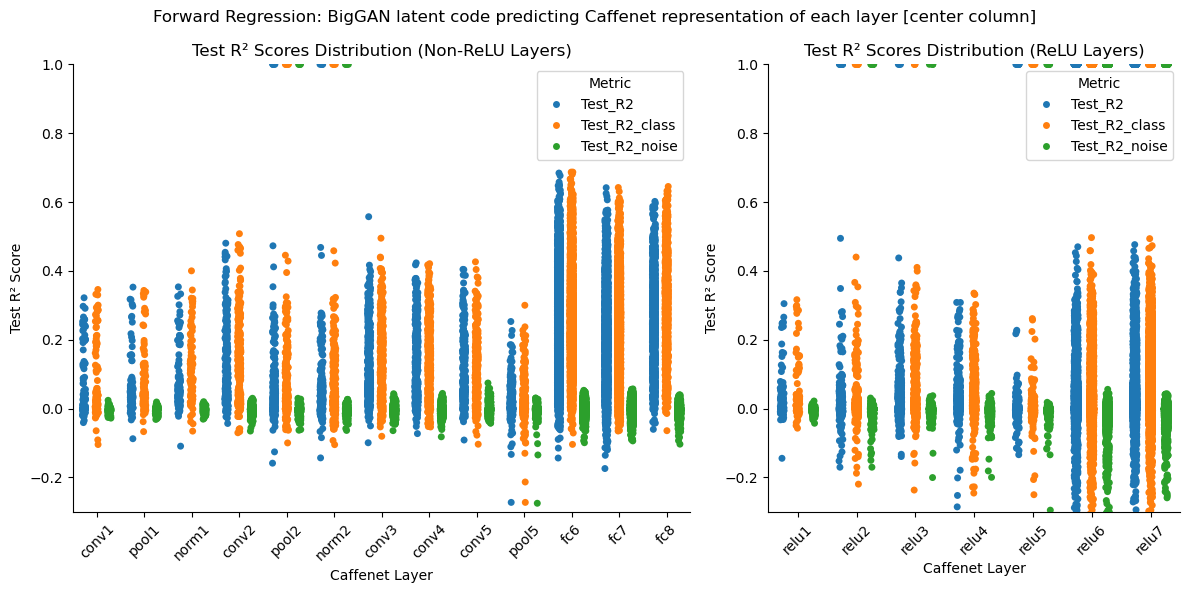

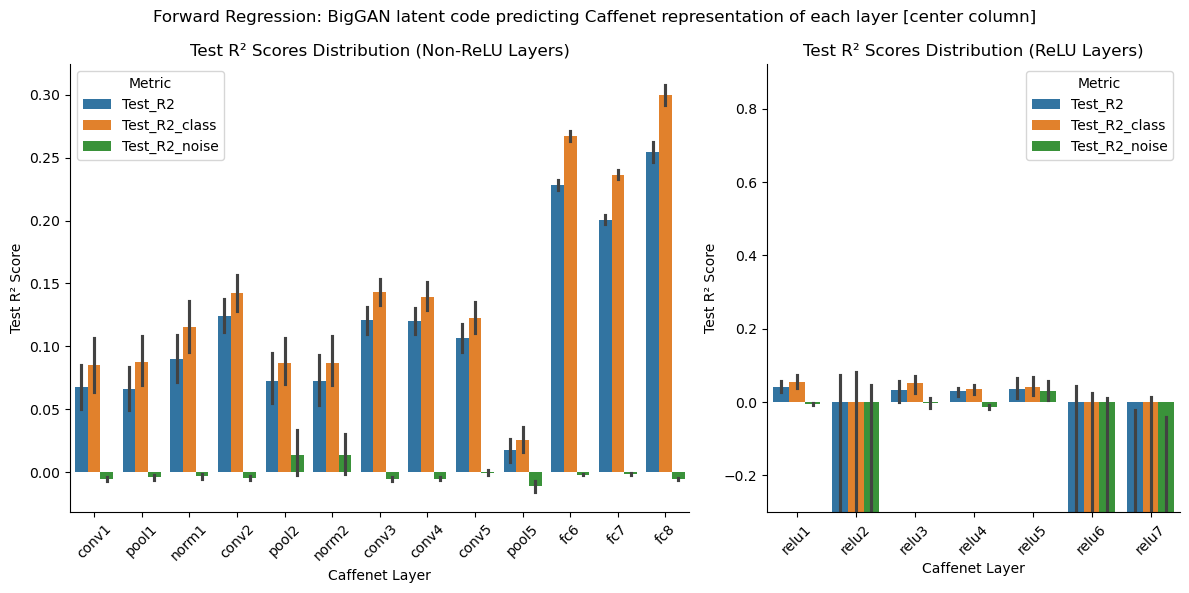

In [69]:
noise_std = 0.06
random_center_vector = G.sample_vector(1, class_id=256)
latent_codes_local_lin = (random_center_vector + noise_std * torch.randn(1000, 256, device=device)).detach()
local_lin_activation_storage = process_latent_codes(latent_codes_local_lin, G, caffenet_model, fetcher)
local_lin_results_df = forward_regression_predict_activations(local_lin_activation_storage, latent_codes_local_lin)
local_lin_reverse_results_df = reverse_regression_predict_latent_codes(local_lin_activation_storage, latent_codes_local_lin)
plot_forward_r2_scores_distribution(local_lin_results_df, plot_type="stripplot");
plot_forward_r2_scores_distribution(local_lin_results_df, plot_type="barplot");
# plot_reverse_regression_results(local_lin_reverse_results_df, )

  0%|          | 0/16 [00:00<?, ?it/s]

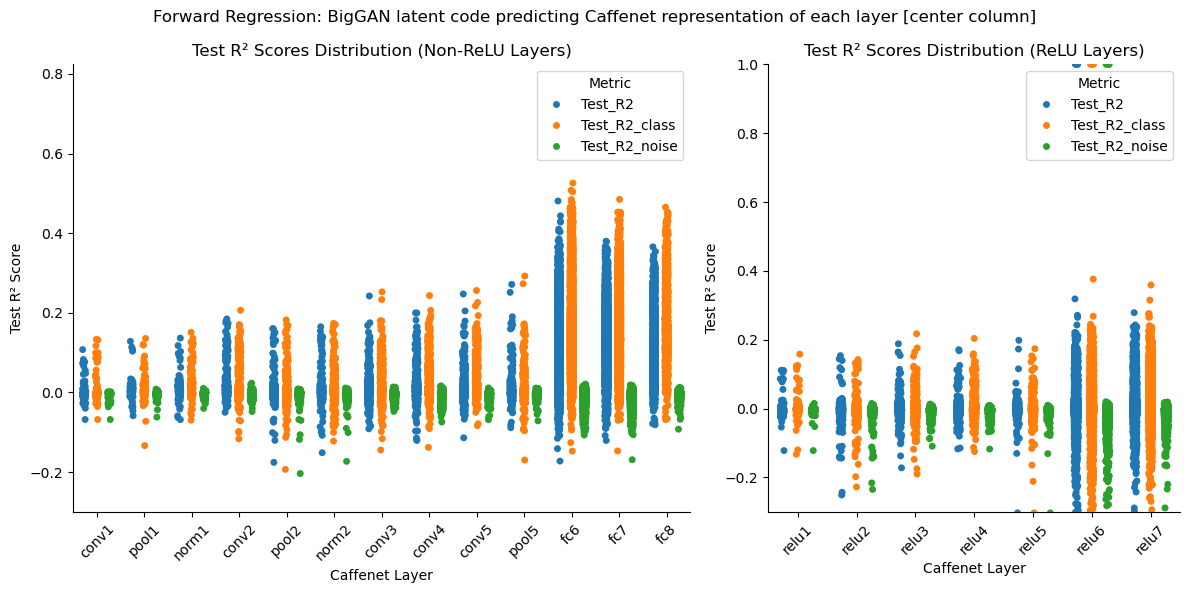

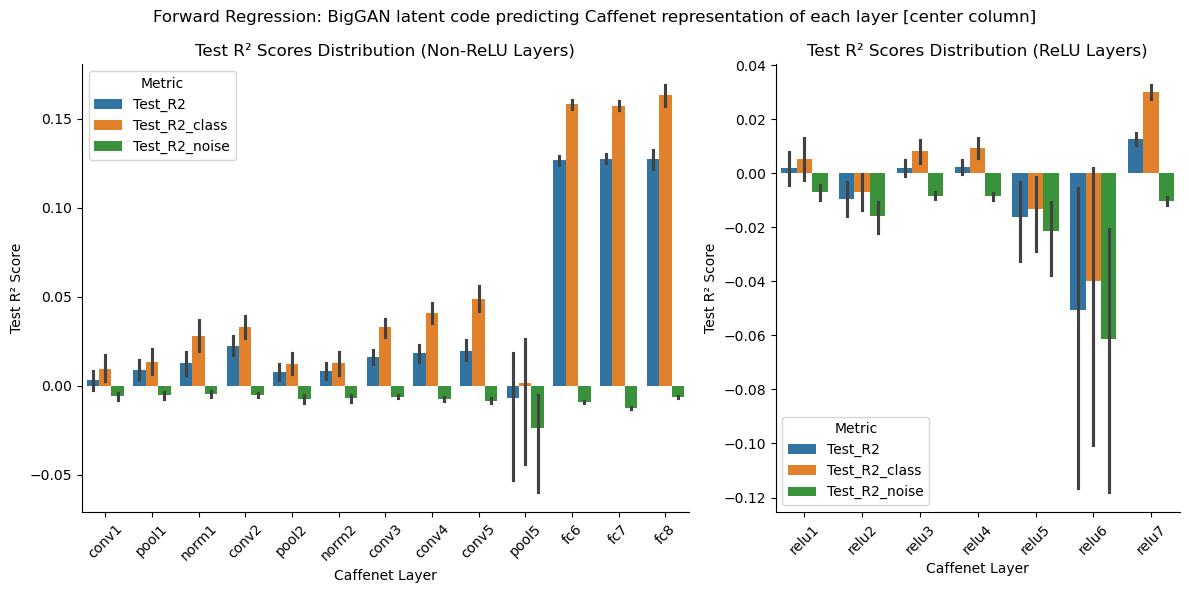

In [72]:
noise_std = 0.12
random_center_vector = G.sample_vector(1, class_id=256)
latent_codes_local_lin = (random_center_vector + noise_std * torch.randn(1000, 256, device=device)).detach()
local_lin_activation_storage = process_latent_codes(latent_codes_local_lin, G, caffenet_model, fetcher)
local_lin_results_df = forward_regression_predict_activations(local_lin_activation_storage, latent_codes_local_lin)
local_lin_reverse_results_df = reverse_regression_predict_latent_codes(local_lin_activation_storage, latent_codes_local_lin)
plot_forward_r2_scores_distribution(local_lin_results_df, plot_type="stripplot");
plot_forward_r2_scores_distribution(local_lin_results_df, plot_type="barplot");

  0%|          | 0/16 [00:00<?, ?it/s]

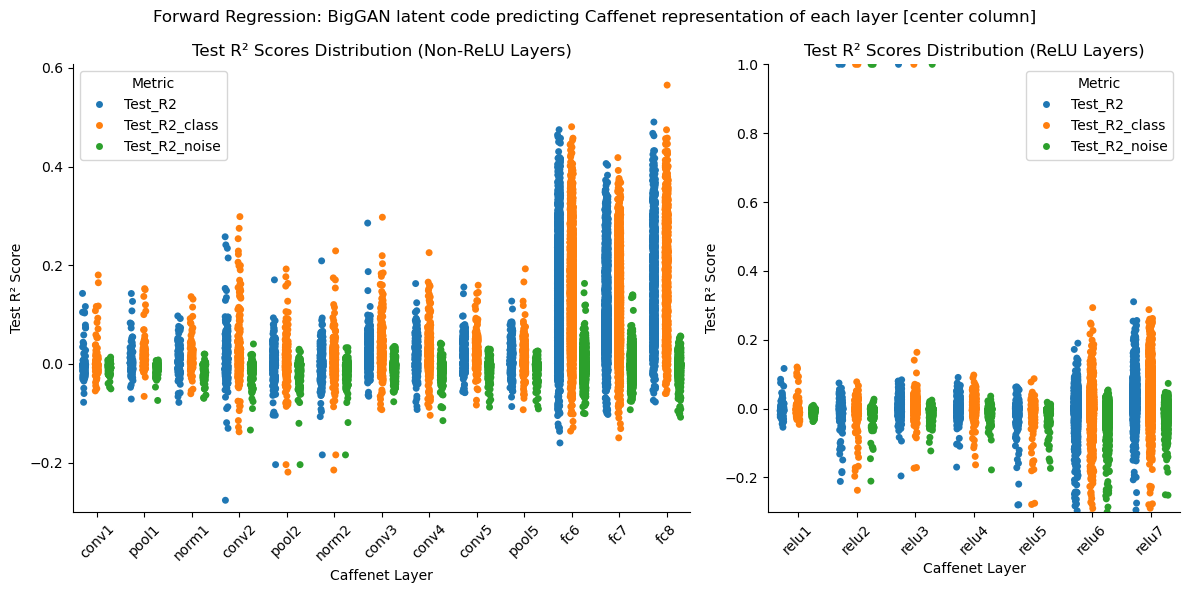

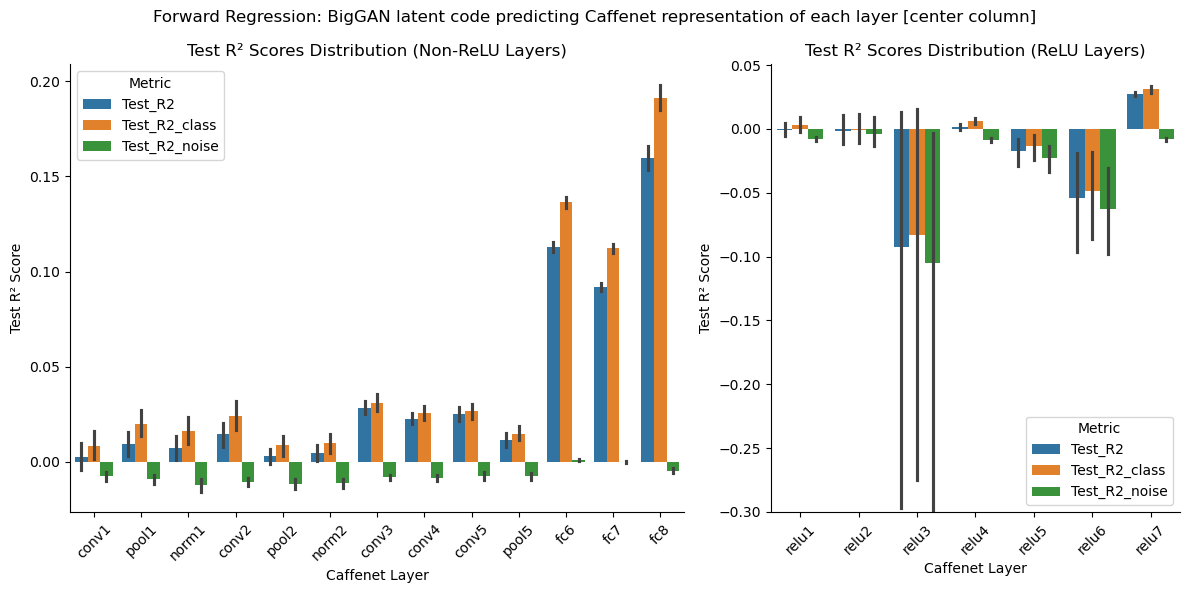

: 

In [73]:
noise_std = 0.20
random_center_vector = G.sample_vector(1, class_id=256)
latent_codes_local_lin = (random_center_vector + noise_std * torch.randn(1000, 256, device=device)).detach()
local_lin_activation_storage = process_latent_codes(latent_codes_local_lin, G, caffenet_model, fetcher)
local_lin_results_df = forward_regression_predict_activations(local_lin_activation_storage, latent_codes_local_lin)
local_lin_reverse_results_df = reverse_regression_predict_latent_codes(local_lin_activation_storage, latent_codes_local_lin)
plot_forward_r2_scores_distribution(local_lin_results_df, plot_type="stripplot");
plot_forward_r2_scores_distribution(local_lin_results_df, plot_type="barplot");

### DeePSim CaffeNet    

In [59]:
from tqdm.auto import trange, tqdm
from collections import defaultdict
from core.utils.GAN_utils import upconvGAN


In [63]:
def get_center_activation(tensor, max_channel=None):
    if max_channel is None:
        max_channel = tensor.shape[1]
    if len(tensor.shape) == 2:
        return tensor[:, :max_channel]
    elif len(tensor.shape) == 4:
        B, C, H, W = tensor.shape
        return tensor[:, :max_channel, H//2, W//2]
    else:
        raise ValueError(f"Expected tensor with 2 or 4 dimensions, got {len(tensor.shape)}")

In [60]:
# Initialize Caffenet
caffenet_model = Caffenet()
caffenet_model.to(device)
caffenet_model.eval()

# Initialize BigGAN
DP_G = upconvGAN("fc6").to(device).eval()


In [79]:
# Sampling 5000 random latent codes
num_samples = 5000
latent_codes_all = 4 * torch.randn(num_samples, 4096).to(device)

In [80]:
fetcher = featureFetcher_module()

for name, layer in caffenet_model.net.named_children():
    if name == "flatten":
        continue
    fetcher.record_module(layer, name, ingraph=False, store_device="cpu")


In [81]:
# Define transformation to match Caffenet input requirements
transform = transforms.Compose([
    transforms.Resize(224),
    # Note no need to normalize, as the model perform normalization inside
])

activation_storage = defaultdict(list)

# Create DataLoader for batch processing
batch_size = 50
for csr in trange(0, len(latent_codes_all), batch_size):
    latent_codes_all_batch = latent_codes_all[csr:csr+batch_size]
    imgs = DP_G.visualize(latent_codes_all_batch)
    imgs = transform(imgs)
    with torch.no_grad():
        _ = caffenet_model(imgs, preproc=True)
    
    for name, activation in fetcher.activations.items():
        activation_storage[name].append(get_center_activation(activation))

# Concatenate activations
for layer in activation_storage:
    activation_storage[layer] = torch.cat(activation_storage[layer], dim=0)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


In [82]:
for layer in activation_storage:
    print(layer, activation_storage[layer].shape)

conv1 torch.Size([5000, 96])
relu1 torch.Size([5000, 96])
pool1 torch.Size([5000, 96])
norm1 torch.Size([5000, 96])
conv2 torch.Size([5000, 256])
relu2 torch.Size([5000, 256])
pool2 torch.Size([5000, 256])
norm2 torch.Size([5000, 256])
conv3 torch.Size([5000, 384])
relu3 torch.Size([5000, 384])
conv4 torch.Size([5000, 384])
relu4 torch.Size([5000, 384])
conv5 torch.Size([5000, 256])
relu5 torch.Size([5000, 256])
pool5 torch.Size([5000, 256])
fc6 torch.Size([5000, 4096])
relu6 torch.Size([5000, 4096])
fc7 torch.Size([5000, 4096])
relu7 torch.Size([5000, 4096])
fc8 torch.Size([5000, 1000])


In [ ]:
# Load the Hessian eigenspace 

In [83]:
X = latent_codes_all.cpu().numpy()
results = []

for layer, activation in activation_storage.items():
    # For each target neuron in the layer
    target_idx = np.arange(activation.shape[1])
    y = activation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Ridge Regression
    ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train, y_train)
    # Calculate R2 score for each target neuron using vectorized operation
    r2_train = r2_score(y_train, ridge.predict(X_train), multioutput='raw_values')
    r2_scores = r2_score(y_test, ridge.predict(X_test), multioutput='raw_values')
    
    # Create dictionary entries for all targets at once
    results.extend([{
        'Layer': layer,
        'Target': idx,
        'Train_R2': r2_train[idx],
        'Test_R2': r2_scores[idx],
    } for idx in zip(target_idx)])


# Summarize results
results_df = pd.DataFrame(results)

In [84]:
import pickle as pkl
from os.path import join
from core.utils.plot_utils import saveallforms
savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\DeePSim_FC6_Caffenet"
os.makedirs(savedir, exist_ok=True)

# Save the full results DataFrame
results_df.to_csv(join(savedir, "latent_code_linearity_results.csv"), index=False)

# Save summary statistics per layer
layer_summary = results_df.groupby('Layer').agg({
    'Test_R2': ['mean', 'std', 'median'],

}).round(4)
layer_summary.to_csv(join(savedir, "layer_summary_stats.csv"))

# Save the raw data used for analysis
pkl.dump({"latent_codes": latent_codes_all.cpu(), 
          "activation_storage": activation_storage}, open(join(savedir, "DeePSim_FC6_Caffenet_data.pkl"), "wb"))

In [ ]:
# Plot the results
for y_variable in ["Test_R2", ]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot for layers without relu
    sns.violinplot(x='Layer', y=y_variable, 
            data=results_df.query('not Layer.str.contains("relu")'), 
            ax=ax1, cut=0)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title(f'Test R² Scores {y_variable} Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    # Plot for relu layers
    sns.violinplot(x='Layer', y=y_variable,
            data=results_df.query('Layer.str.contains("relu")'),
            ax=ax2, cut=0)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores {y_variable} Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    # clip y axis
    ax2.set_ylim(-0.3, 1)
    plt.suptitle(f"DeePSim FC6 latent code x Caffenet representatio {y_variable} Violinplot")
    plt.tight_layout()
    saveallforms(savedir, f"DeePSim_FC6_Caffenet_{y_variable}_violinplot")
    plt.show()

In [ ]:
# Plot the results
for y_variable in ["Test_R2", ]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot for layers without relu
    sns.boxplot(x='Layer', y=y_variable, 
            data=results_df.query('not Layer.str.contains("relu")'), 
            ax=ax1)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title(f'Test R² Scores {y_variable} Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    # Plot for relu layers
    sns.boxplot(x='Layer', y=y_variable,
            data=results_df.query('Layer.str.contains("relu")'),
            ax=ax2)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores {y_variable} Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    # clip y axis
    ax2.set_ylim(-0.3, 1)
    plt.suptitle(f"DeePSim FC6 latent code x Caffenet representatio {y_variable} Boxplot")
    plt.tight_layout()
    saveallforms(savedir, f"DeePSim_FC6_Caffenet_{y_variable}_boxplot")
    plt.show()